In [1]:
# Import stuff
import random, copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Set random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# Create environment for One Turn Zombie Dice game

# Dice class
class Dice:
    def __init__(self, brains_count, feet_count, shots_count, color):
        self.brains_count = brains_count
        self.feet_count = feet_count
        self.shots_count = shots_count
        self.total = brains_count + feet_count + shots_count
        self.color = color
        
    def roll(self):
        n = np.random.randint(self.total)
        if n < self.brains_count:
            return 'brain'
        elif n < self.brains_count + self.feet_count:
            return 'feet'
        else:
            return 'shot'
        
# Cup class
class Cup:
    def __init__(self, green_dice_count=6, yellow_dice_count=4, red_dice_count=3):
        self.cup = []
        
        # Add green dice
        for _ in range(green_dice_count):
            self.cup.append(Dice(3, 2, 1, 'green'))
            
        # Add yellow dice
        for _ in range(yellow_dice_count):
            self.cup.append(Dice(2, 2, 2, 'yellow'))
            
        # Add red dice
        for _ in range(red_dice_count):
            self.cup.append(Dice(1, 2, 3, 'red'))
            
    def size(self):
        return len(self.cup)
        
    def shake(self):
        random.shuffle(self.cup)
        
    def draw(self, n=3):
        # Draw n dice from the cup, or return None if there's not enough dice
        if self.size() < n:
            return None
        
        self.shake()
        result = []
        for _ in range(n):
            result.append(self.cup[-1])
            del self.cup[-1]
        return result
            
    def refill(self, dice_refill):
        # Refill the cup with some dice
        for dice in dice_refill:
            self.cup.append(dice)
            
# Utility function to count number of dice by color
def count_color(dice_list):
    green_count, yellow_count, red_count = 0, 0, 0
    for dice in dice_list:
        if dice.color is 'green':
            green_count += 1
        elif dice.color is 'yellow':
            yellow_count += 1
        else:
            red_count += 1
    return (green_count, yellow_count, red_count)
            
# Game environment class
class OneTurnZombieDice:
    def __init__(self):
        self.cup = Cup()
        self.hand = []
        self.brains = []
        self.feet = []
        self.shots = []
        self.n_actions = 2
        self.score = 0
        
    def get_state(self):
        # Return numbers of green, yellow, and red dice in each slot
        return (*count_color(self.cup.cup),
                *count_color(self.brains),
                *count_color(self.feet),
                *count_color(self.shots))
    
    def reset(self):
        self.__init__()
        return self.get_state()
    
    def step(self, action):
        state, reward, done, info = self.get_state(), 0, False, None
        
        if action == 0:
            # End game, return total number of brains obtained as score
            reward = self.score + len(self.brains)
            done = True
        else:
            # Draw dice and roll
            # Reroll dice that got feet
            for dice in self.feet:
                self.hand.append(dice)
            self.feet = []
            
            # Fill hand by drawing from the cup
            drawn_dice = self.cup.draw(3 - len(self.hand))
            if drawn_dice is None:
                # Not enough dice in cup, refill it
                self.score += len(self.brains)
                self.cup.refill(self.brains)
                self.brains = []
                drawn_dice = self.cup.draw(3 - len(self.hand))
            for dice in drawn_dice:
                self.hand.append(dice)
                
            # Roll dice
            for dice in self.hand:
                result = dice.roll()
                if result == 'brain':
                    self.brains.append(dice)
                elif result == 'feet':
                    self.feet.append(dice)
                else:
                    self.shots.append(dice)
                    # Check for game over
                    if len(self.shots) >= 3:
                        done = True
            self.hand = []
            
            state = self.get_state()
            
        return (state, reward, done, info)

In [3]:
# Policy network class
class PolicyNetwork(nn.Module):
    def __init__(self, n_inputs, hidden_size, n_outputs):
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, hidden_size)
        self.fc2 = nn.Linear(hidden_size, n_outputs)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Agent class
class Agent:
    def __init__(self, hidden_size=36, learning_rate=1e-3):
        self.policy = PolicyNetwork(12, hidden_size, 2).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        
    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(0)
        probs = F.softmax(self.policy(state), dim=1)
        action = np.random.choice(2, p=probs.cpu().detach().numpy().ravel())
        log_prob = torch.log(probs[0, action])
        return (action, log_prob)
    
    def get_probs(self, state):
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(0)
            probs = F.softmax(self.policy(state), dim=1)
        return probs
    
    def update_parameters(self, all_rewards, all_log_probs, discount_rate=0.9):
        # Compute discounted rewards
        all_discounted_rewards = []
        for rewards in all_rewards:    
            total_reward = 0
            discounted_rewards = [0] * len(rewards)
            for i in reversed(range(len(rewards))):
                discounted_rewards[i] = rewards[i] + discount_rate * total_reward
                total_reward = discounted_rewards[i]
            all_discounted_rewards.append(discounted_rewards)

        # Stack all rewards and log-probs
        flat_discounted_rewards = [r for rewards in all_discounted_rewards for r in rewards]
        flat_log_probs = [lp for log_probs in all_log_probs for lp in log_probs]
        
        # Convert to tensors
        discounted_rewards = torch.tensor(flat_discounted_rewards).to(device)
        log_probs = torch.stack(flat_log_probs).to(device)
        
        # Normalize rewards. This speeds up training by reducing variance.
        normalized_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)
        
        # Reset parameter gradients
        self.optimizer.zero_grad()
        
        # Get "loss". This isn't the actual loss function, but its gradient matches the
        # gradient of the actual loss function.
        loss = torch.mul(normalized_rewards, -log_probs).sum()
        
        # Perform back-propagation
        loss.backward()
        
        # Optimize
        self.optimizer.step()

In [4]:
# Save model?

# Initialize environment and agent
env = OneTurnZombieDice()
agent = Agent()

# Track average scores
avg_scores = []

# Training hyperparameters
n_epochs = 5000
episodes_per_epoch = 50
discount_rate = 0.9
print_interval = 100

# Training loop
for epoch in range(n_epochs):
    all_rewards = []  # This 2D reward array is really ugly, consider changing it to 1D only
    all_log_probs = []
    avg_score = 0
    
    for episode in range(episodes_per_epoch):
        rewards = []
        log_probs = []
        score = 0
        
        # Collect trajectory
        state = env.reset()
        done = False
        while not done:
            action, log_prob = agent.get_action(state)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            log_probs.append(log_prob)
            score += reward
            
        all_rewards.append(rewards)
        all_log_probs.append(log_probs)
        avg_score += score
        
    # Update agent parameters
    agent.update_parameters(all_rewards, all_log_probs, discount_rate)
    
    # Record average score
    avg_score /= episodes_per_epoch
    avg_scores.append(avg_score)
    
    if epoch % print_interval == 0:
        print("Epoch {}: {}".format(epoch, avg_score))

Epoch 0: 0.46
Epoch 100: 1.84
Epoch 200: 1.52
Epoch 300: 2.26
Epoch 400: 1.9
Epoch 500: 2.38
Epoch 600: 1.9
Epoch 700: 2.56
Epoch 800: 2.04
Epoch 900: 2.28
Epoch 1000: 2.66
Epoch 1100: 1.92
Epoch 1200: 1.96
Epoch 1300: 2.08
Epoch 1400: 2.34
Epoch 1500: 2.38
Epoch 1600: 1.84
Epoch 1700: 2.32
Epoch 1800: 2.48
Epoch 1900: 2.18
Epoch 2000: 2.24
Epoch 2100: 2.18
Epoch 2200: 1.94
Epoch 2300: 2.22
Epoch 2400: 2.18
Epoch 2500: 2.8
Epoch 2600: 1.94
Epoch 2700: 2.14
Epoch 2800: 1.98
Epoch 2900: 1.94
Epoch 3000: 2.36
Epoch 3100: 2.22
Epoch 3200: 2.58
Epoch 3300: 2.14
Epoch 3400: 2.2
Epoch 3500: 1.96
Epoch 3600: 1.82
Epoch 3700: 2.44
Epoch 3800: 2.12
Epoch 3900: 2.5
Epoch 4000: 2.18
Epoch 4100: 1.94
Epoch 4200: 2.56
Epoch 4300: 2.1
Epoch 4400: 2.46
Epoch 4500: 2.46
Epoch 4600: 1.94
Epoch 4700: 2.2
Epoch 4800: 1.8
Epoch 4900: 2.1


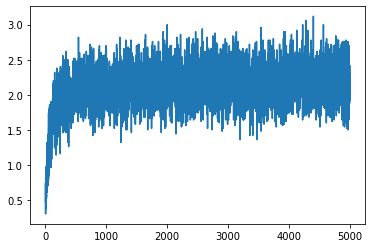

In [5]:
plt.plot(avg_scores)

In [6]:
# Function to simulate one episode
def simulate(env, agent, detailed=False):
    state = env.reset()
    if detailed:
        print(state)
    score = 0
    done = False
    while not done:
        action, _ = agent.get_action(state)
        if detailed:
            probs = agent.get_probs(state)
            print(probs.cpu().numpy(), action)
        state, reward, done, _ = env.step(action)
        if detailed:
            print(state)
        score += reward
    return score

Counts: [28751, 10451, 15100, 19562, 15684, 7142, 2513, 663, 119, 15, 0, 0]
Ratio: [0.28751, 0.10451, 0.151, 0.19562, 0.15684, 0.07142, 0.02513, 0.00663, 0.00119, 0.00015, 0.0, 0.0]
Mean: 2.18589


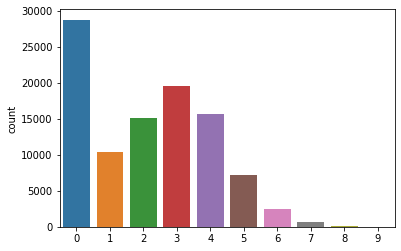

In [7]:
# Plot score distribution
results = []
counts = [0] * 12
n = 100000
for _ in range(n):
    score = simulate(env, agent)
    results.append(score)
    counts[score] += 1
print("Counts:", counts)
print("Ratio:", [count / n for count in counts])
print("Mean:", sum(results) / n)
sns.countplot(results)

In [8]:
for _ in range(10):
    print("=== NEW GAME ===")
    score = simulate(env, agent, detailed=True)
    print("Score:", score)

=== NEW GAME ===
(6, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
[[1.0681913e-09 1.0000000e+00]] 1
(3, 4, 3, 2, 0, 0, 1, 0, 0, 0, 0, 0)
[[9.7049463e-07 9.9999905e-01]] 1
(3, 3, 2, 3, 0, 0, 0, 0, 0, 0, 1, 1)
[[9.9998903e-01 1.0931855e-05]] 0
(3, 3, 2, 3, 0, 0, 0, 0, 0, 0, 1, 1)
Score: 3
=== NEW GAME ===
(6, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
[[1.0681913e-09 1.0000000e+00]] 1
(5, 3, 2, 1, 0, 0, 0, 1, 1, 0, 0, 0)
[[6.5969266e-07 9.9999928e-01]] 1
(4, 3, 2, 2, 0, 0, 0, 0, 1, 0, 1, 0)
[[0.26744193 0.7325581 ]] 0
(4, 3, 2, 2, 0, 0, 0, 0, 1, 0, 1, 0)
Score: 2
=== NEW GAME ===
(6, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
[[1.0681913e-09 1.0000000e+00]] 1
(4, 3, 3, 0, 1, 0, 1, 0, 0, 1, 0, 0)
[[1.0086438e-05 9.9998987e-01]] 1
(3, 2, 3, 2, 2, 0, 0, 0, 0, 1, 0, 0)
[[0.99491066 0.00508933]] 0
(3, 2, 3, 2, 2, 0, 0, 0, 0, 1, 0, 0)
Score: 4
=== NEW GAME ===
(6, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
[[1.0681913e-09 1.0000000e+00]] 1
(4, 3, 3, 1, 1, 0, 1, 0, 0, 0, 0, 0)
[[2.8812707e-07 9.9999976e-01]] 1
(3, 3, 2, 1, 1, 0, 1, 0, 

In [9]:
# Compute probability of winning a 2-player game for all pairs of scores
def simulate_two_player_game(agent1, agent2, starting_score1=0, starting_score2=0, player2_move_first=False):
    env = OneTurnZombieDice()
    score1 = starting_score1
    score2 = starting_score2
    
    if player2_move_first:
        score2 += simulate(env, agent2)
    
    while True:
        if score1 >= 13 or score2 >= 13:
            if score1 > score2:
                return 1
            elif score1 < score2:
                return 2
            
        score1 += simulate(env, agent1)
        score2 += simulate(env, agent2)
        
win_probs_move1 = np.zeros((13, 13))
win_probs_move2 = np.zeros((13, 13))
trials_per_pair = 1000

for starting_score1 in range(13):
    for starting_score2 in range(13):
        total_win1 = 0
        total_win2 = 0
        for trial in range(trials_per_pair):
            if simulate_two_player_game(agent, agent, starting_score1, starting_score2, False) == 1:
                total_win1 += 1
            if simulate_two_player_game(agent, agent, starting_score1, starting_score2, True) == 1:
                total_win2 += 1
        win_probs_move1[starting_score1, starting_score2] = total_win1 / trials_per_pair
        win_probs_move2[starting_score1, starting_score2] = total_win2 / trials_per_pair
        print(starting_score1, starting_score2, total_win1 / trials_per_pair)

0 0 0.532
0 1 0.436
0 2 0.378
0 3 0.302
0 4 0.235
0 5 0.191
0 6 0.133
0 7 0.083
0 8 0.066
0 9 0.049
0 10 0.03
0 11 0.01
0 12 0.007
1 0 0.539
1 1 0.495
1 2 0.464
1 3 0.36
1 4 0.276
1 5 0.234
1 6 0.167
1 7 0.133
1 8 0.089
1 9 0.047
1 10 0.023
1 11 0.012
1 12 0.006
2 0 0.655
2 1 0.556
2 2 0.506
2 3 0.4
2 4 0.355
2 5 0.275
2 6 0.188
2 7 0.176
2 8 0.106
2 9 0.056
2 10 0.031
2 11 0.02
2 12 0.011
3 0 0.68
3 1 0.654
3 2 0.576
3 3 0.48
3 4 0.432
3 5 0.337
3 6 0.275
3 7 0.215
3 8 0.14
3 9 0.086
3 10 0.049
3 11 0.026
3 12 0.016
4 0 0.745
4 1 0.729
4 2 0.652
4 3 0.59
4 4 0.497
4 5 0.421
4 6 0.306
4 7 0.273
4 8 0.189
4 9 0.131
4 10 0.078
4 11 0.037
4 12 0.019
5 0 0.806
5 1 0.774
5 2 0.721
5 3 0.656
5 4 0.601
5 5 0.483
5 6 0.406
5 7 0.318
5 8 0.255
5 9 0.165
5 10 0.102
5 11 0.052
5 12 0.023
6 0 0.86
6 1 0.847
6 2 0.757
6 3 0.691
6 4 0.659
6 5 0.619
6 6 0.497
6 7 0.394
6 8 0.332
6 9 0.238
6 10 0.141
6 11 0.083
6 12 0.058
7 0 0.897
7 1 0.885
7 2 0.836
7 3 0.813
7 4 0.75
7 5 0.65
7 6 0.581
7 7 0.5
7 8 

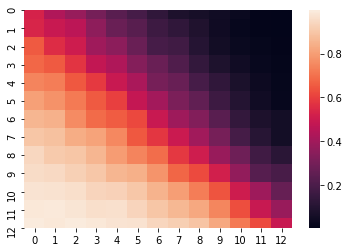

In [10]:
sns.heatmap(win_probs_move1)

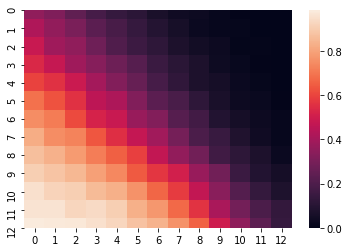

In [11]:
sns.heatmap(win_probs_move2)

In [12]:
print("Probabilities of winning if player 1 moves first:")
print(win_probs_move1)

Probabilities of winning if player 1 moves first:
[[0.532 0.436 0.378 0.302 0.235 0.191 0.133 0.083 0.066 0.049 0.03  0.01
  0.007]
 [0.539 0.495 0.464 0.36  0.276 0.234 0.167 0.133 0.089 0.047 0.023 0.012
  0.006]
 [0.655 0.556 0.506 0.4   0.355 0.275 0.188 0.176 0.106 0.056 0.031 0.02
  0.011]
 [0.68  0.654 0.576 0.48  0.432 0.337 0.275 0.215 0.14  0.086 0.049 0.026
  0.016]
 [0.745 0.729 0.652 0.59  0.497 0.421 0.306 0.273 0.189 0.131 0.078 0.037
  0.019]
 [0.806 0.774 0.721 0.656 0.601 0.483 0.406 0.318 0.255 0.165 0.102 0.052
  0.023]
 [0.86  0.847 0.757 0.691 0.659 0.619 0.497 0.394 0.332 0.238 0.141 0.083
  0.058]
 [0.897 0.885 0.836 0.813 0.75  0.65  0.581 0.5   0.403 0.305 0.187 0.108
  0.058]
 [0.945 0.91  0.897 0.858 0.796 0.745 0.692 0.586 0.51  0.383 0.287 0.175
  0.117]
 [0.958 0.95  0.927 0.903 0.861 0.845 0.78  0.677 0.625 0.52  0.367 0.23
  0.195]
 [0.976 0.971 0.966 0.937 0.931 0.902 0.853 0.8   0.728 0.642 0.507 0.394
  0.266]
 [0.988 0.991 0.979 0.966 0.968 0.938 0.

In [13]:
print("Probabilities of winning if player 2 moves first:")
print(win_probs_move2)

Probabilities of winning if player 2 moves first:
[[0.355 0.318 0.242 0.184 0.142 0.114 0.068 0.04  0.033 0.017 0.005 0.002
  0.001]
 [0.423 0.36  0.305 0.234 0.187 0.142 0.093 0.059 0.028 0.016 0.012 0.003
  0.001]
 [0.487 0.39  0.357 0.277 0.204 0.155 0.12  0.073 0.047 0.031 0.011 0.011
  0.   ]
 [0.537 0.478 0.39  0.333 0.275 0.221 0.153 0.108 0.076 0.036 0.021 0.006
  0.003]
 [0.599 0.558 0.488 0.403 0.326 0.259 0.183 0.126 0.076 0.056 0.029 0.015
  0.003]
 [0.688 0.629 0.557 0.458 0.42  0.319 0.232 0.189 0.122 0.068 0.032 0.025
  0.006]
 [0.751 0.711 0.614 0.519 0.486 0.373 0.324 0.222 0.169 0.091 0.055 0.031
  0.016]
 [0.823 0.751 0.726 0.634 0.552 0.476 0.393 0.293 0.192 0.149 0.082 0.041
  0.018]
 [0.87  0.836 0.78  0.717 0.654 0.59  0.469 0.358 0.285 0.167 0.117 0.076
  0.029]
 [0.909 0.88  0.852 0.793 0.741 0.644 0.569 0.508 0.373 0.286 0.153 0.091
  0.057]
 [0.955 0.919 0.91  0.858 0.83  0.761 0.665 0.583 0.469 0.339 0.218 0.137
  0.079]
 [0.96  0.96  0.926 0.939 0.908 0.83 

In [20]:
print("{")
for i, row in enumerate(win_probs_move1):
    print("{", end="")
    for j, num in enumerate(row):
        print("{0:.3f}".format(num), end="")
        if j < 12:
            print(", ", end="")
    if i < 12:
        print("},")
    else:
        print("}")
print("}")

{
{0.532, 0.436, 0.378, 0.302, 0.235, 0.191, 0.133, 0.083, 0.066, 0.049, 0.030, 0.010, 0.007},
{0.539, 0.495, 0.464, 0.360, 0.276, 0.234, 0.167, 0.133, 0.089, 0.047, 0.023, 0.012, 0.006},
{0.655, 0.556, 0.506, 0.400, 0.355, 0.275, 0.188, 0.176, 0.106, 0.056, 0.031, 0.020, 0.011},
{0.680, 0.654, 0.576, 0.480, 0.432, 0.337, 0.275, 0.215, 0.140, 0.086, 0.049, 0.026, 0.016},
{0.745, 0.729, 0.652, 0.590, 0.497, 0.421, 0.306, 0.273, 0.189, 0.131, 0.078, 0.037, 0.019},
{0.806, 0.774, 0.721, 0.656, 0.601, 0.483, 0.406, 0.318, 0.255, 0.165, 0.102, 0.052, 0.023},
{0.860, 0.847, 0.757, 0.691, 0.659, 0.619, 0.497, 0.394, 0.332, 0.238, 0.141, 0.083, 0.058},
{0.897, 0.885, 0.836, 0.813, 0.750, 0.650, 0.581, 0.500, 0.403, 0.305, 0.187, 0.108, 0.058},
{0.945, 0.910, 0.897, 0.858, 0.796, 0.745, 0.692, 0.586, 0.510, 0.383, 0.287, 0.175, 0.117},
{0.958, 0.950, 0.927, 0.903, 0.861, 0.845, 0.780, 0.677, 0.625, 0.520, 0.367, 0.230, 0.195},
{0.976, 0.971, 0.966, 0.937, 0.931, 0.902, 0.853, 0.800, 0.728, 0.64

In [21]:
print("{")
for i, row in enumerate(win_probs_move2):
    print("{", end="")
    for j, num in enumerate(row):
        print("{0:.3f}".format(num), end="")
        if j < 12:
            print(", ", end="")
    if i < 12:
        print("},")
    else:
        print("}")
print("}")

{
{0.355, 0.318, 0.242, 0.184, 0.142, 0.114, 0.068, 0.040, 0.033, 0.017, 0.005, 0.002, 0.001},
{0.423, 0.360, 0.305, 0.234, 0.187, 0.142, 0.093, 0.059, 0.028, 0.016, 0.012, 0.003, 0.001},
{0.487, 0.390, 0.357, 0.277, 0.204, 0.155, 0.120, 0.073, 0.047, 0.031, 0.011, 0.011, 0.000},
{0.537, 0.478, 0.390, 0.333, 0.275, 0.221, 0.153, 0.108, 0.076, 0.036, 0.021, 0.006, 0.003},
{0.599, 0.558, 0.488, 0.403, 0.326, 0.259, 0.183, 0.126, 0.076, 0.056, 0.029, 0.015, 0.003},
{0.688, 0.629, 0.557, 0.458, 0.420, 0.319, 0.232, 0.189, 0.122, 0.068, 0.032, 0.025, 0.006},
{0.751, 0.711, 0.614, 0.519, 0.486, 0.373, 0.324, 0.222, 0.169, 0.091, 0.055, 0.031, 0.016},
{0.823, 0.751, 0.726, 0.634, 0.552, 0.476, 0.393, 0.293, 0.192, 0.149, 0.082, 0.041, 0.018},
{0.870, 0.836, 0.780, 0.717, 0.654, 0.590, 0.469, 0.358, 0.285, 0.167, 0.117, 0.076, 0.029},
{0.909, 0.880, 0.852, 0.793, 0.741, 0.644, 0.569, 0.508, 0.373, 0.286, 0.153, 0.091, 0.057},
{0.955, 0.919, 0.910, 0.858, 0.830, 0.761, 0.665, 0.583, 0.469, 0.33